In [29]:
import json
import string
from itertools import combinations
import graph_tool.all as gt

In [2]:
def extract_lcc(g, directed=False, prune=True):
    g = gt.GraphView(g, vfilt=gt.label_largest_component(g, directed=directed))
    return gt.Graph(g, prune=prune)

In [36]:
filename = "output/bird_adjs.json"
with open(filename, "rt") as f:
    data = f.read()
    links = json.loads(data)

In [37]:
links_distinct = dict()
for link in links:
    lk = (link[0], link[1])
    has_punct = any([x in string.punctuation for x in lk])
    if has_punct:
        continue
    if lk in links_distinct.keys():
        links_distinct[lk] =+ 1
    else:
        links_distinct[lk] = 1

In [38]:
edge_list = [[key[0], key[1], value] for key, value in links_distinct.items()]

In [50]:
birds = list(set(x[0] for x in edge_list))
bird_ids = {bird: idx for idx, bird in enumerate(birds)}
adjectives = list(set(x[1] for x in edge_list))
adjectives_ids = {adjectives: idx+len(birds) for idx, adjectives in enumerate(adjectives)}

### Create network

In [85]:
g = gt.Graph(directed=False)
vtype = g.new_vp('string')
vword = g.new_vp('string')
eweight = g.new_ep("int")
g.vp['type'] = vtype
g.vp['word'] = vword
g.ep['weight'] = eweight
for edge in edge_list:
    bird = edge[0]
    adj = edge[1]
    bird_id = bird_ids[bird]
    adj_id = adjectives_ids[adj]
    e = g.add_edge(adj_id, bird_id)
    g.vp.type[e.source()] = 'adj'
    g.vp.type[e.target()] = 'bird'
    g.vp.word[e.source()] = adj
    g.vp.word[e.target()] = bird
    g.ep.weight[e] = edge[2]

In [86]:
g = extract_lcc(g, prune=True)

In [87]:
is_biparitite, part = gt.is_bipartite(g, partition=True)

In [ ]:
gt.graph_draw(g, vertex_fill_color=part)

### Infer block structure of bipartite network

In [97]:
state = gt.minimize_nested_blockmodel_dl(g)

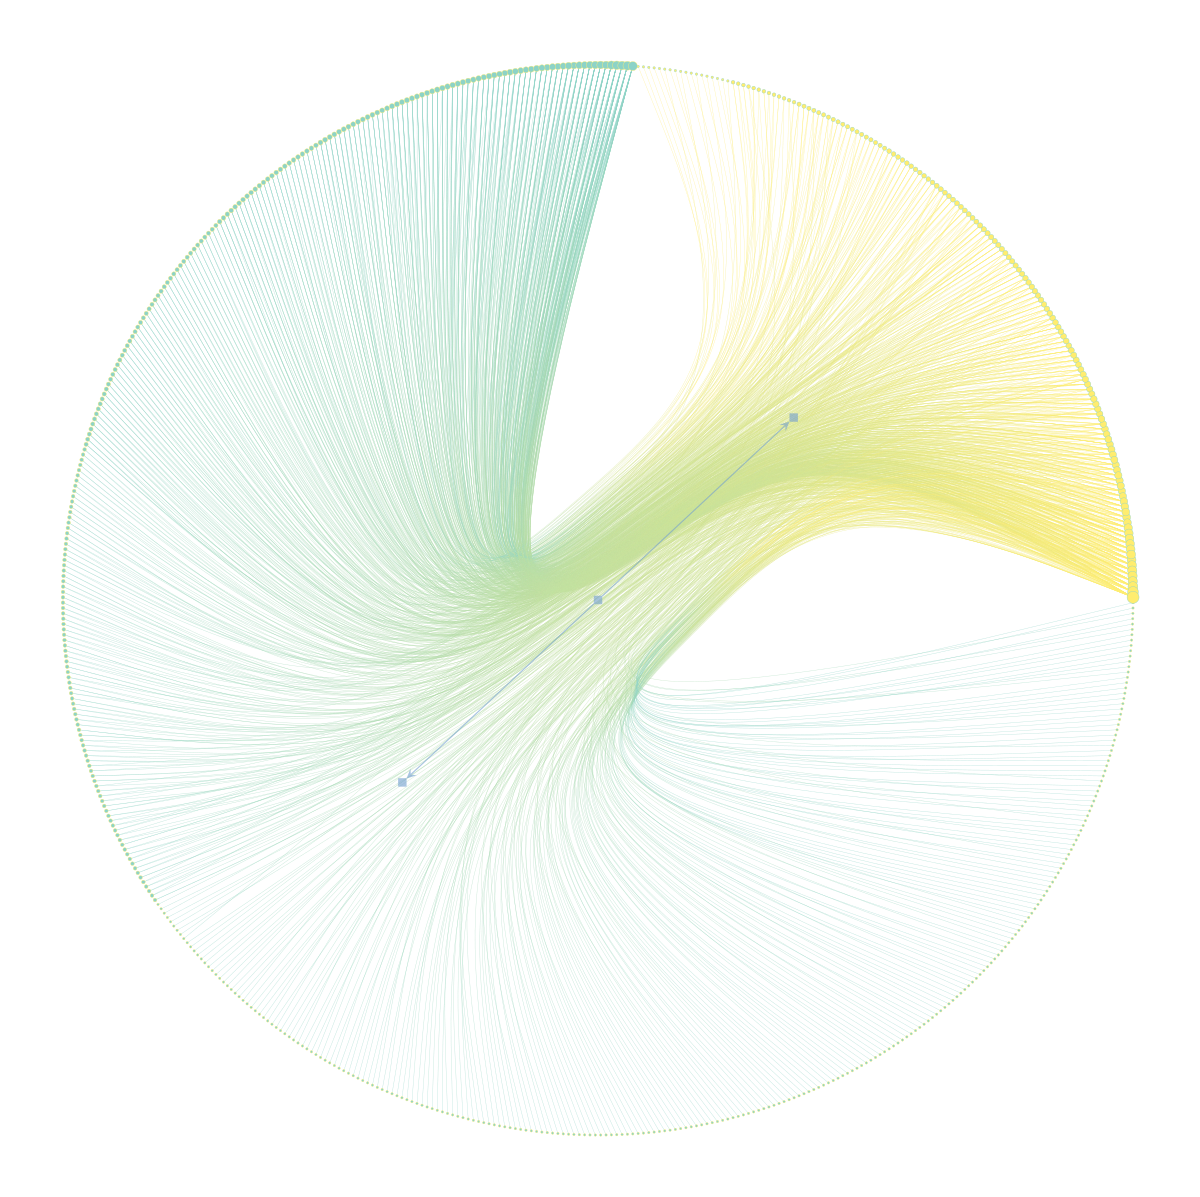

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29f42a160, at 0x29f32b2e0>,
 <GraphView object, directed, with 631 vertices and 630 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x29f45ebe0, at 0x29f465d90>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x29f45ebe0, at 0x29f3705e0>, False), at 0x29f45ebe0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x29f45ebe0, at 0x29f465a60>)

In [98]:
state.draw(vertex_fill_color=part)

### Project bipartite network

In [ ]:
g_temp = g.copy()

for v, bipartite_label in enumerate(part):
    if bipartite_label == 0:
        neighbours = list(g.vertex(v).all_neighbours())

        for s, t in combinations(neighbours, 2):
            g_temp.add_edge(s, t)

g_projected = gt.Graph(gt.GraphView(g_temp, vfilt=part.a==1), prune=True)

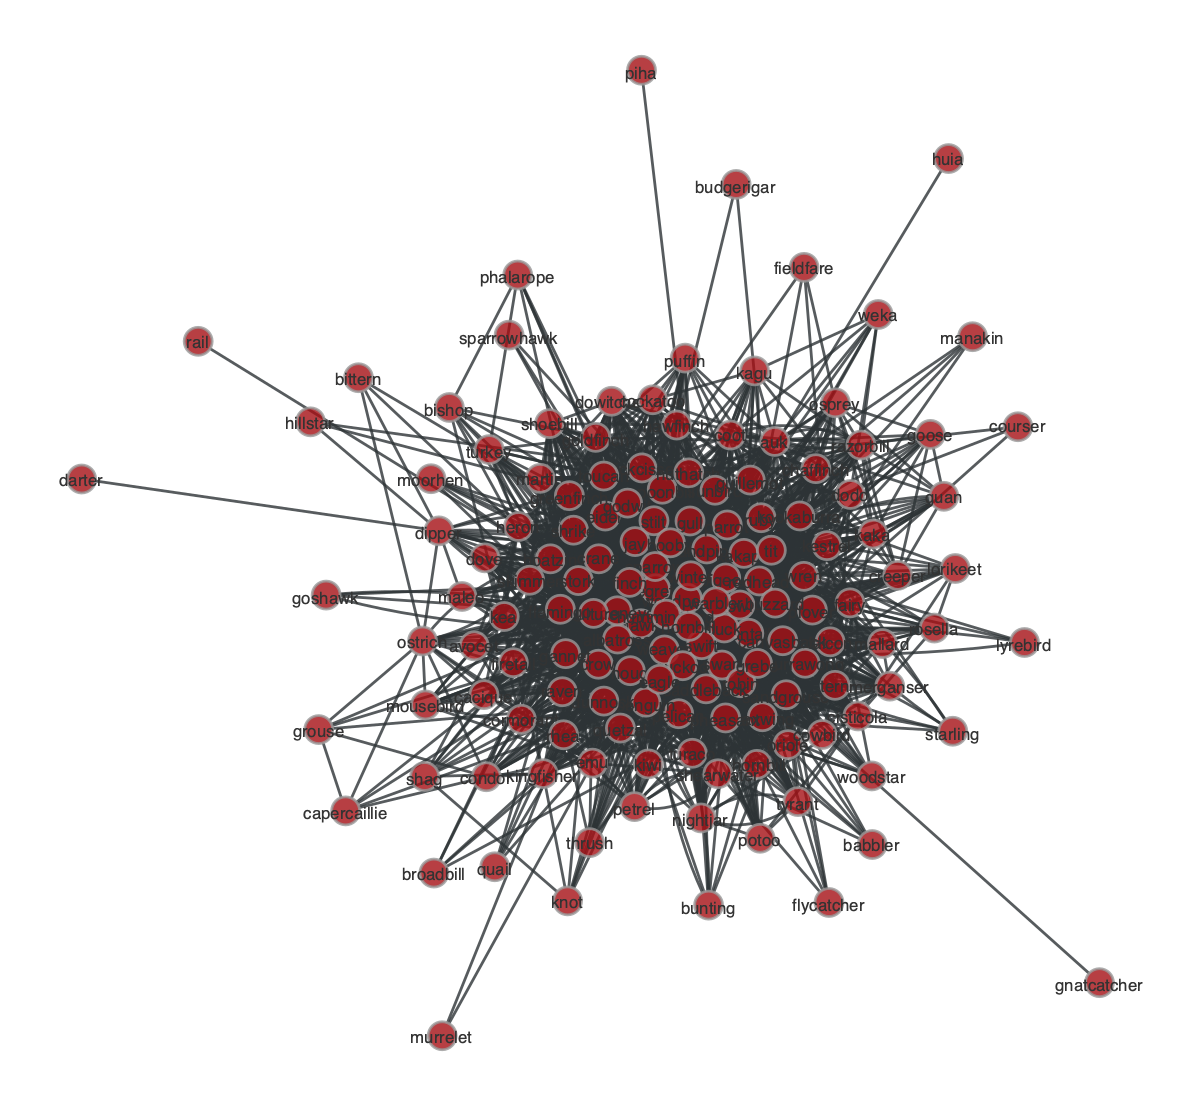

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29f444c40, at 0x29f441a60>

In [96]:
gt.graph_draw(g_projected,
              vertex_text=g_projected.vp['word'],
              vertex_text_position=-.1,
              vertex_text_offset=[-.02,.02],
              vertex_text_color=[.2,.2,.2,1],
              vertex_font_family='Utopia')

### Infer block structure of projected network

In [103]:
state_projected = gt.minimize_nested_blockmodel_dl(g_projected)

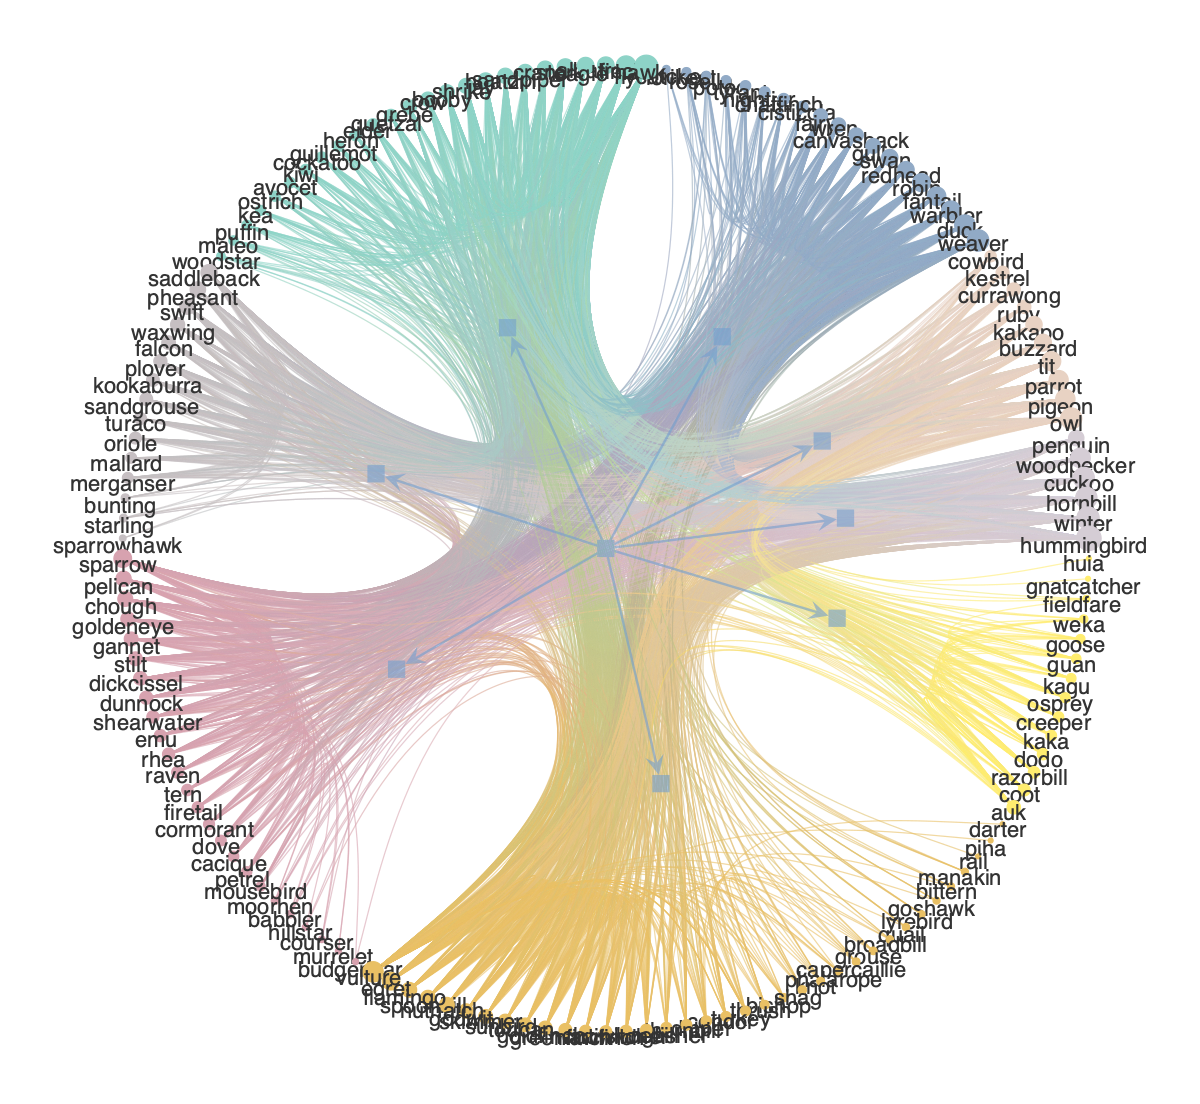

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x29f444c40, at 0x2c1eba940>,
 <GraphView object, directed, with 159 vertices and 158 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x2c2ce9070, at 0x2c2cf05e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x2c2ce9070, at 0x2c1e82970>, False), at 0x2c2ce9070>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x2c2ce9070, at 0x2c2ce99d0>)

In [112]:
state_projected.draw(vertex_text=g_projected.vp['word'],
                     vertex_text_position=-.1,
                     vertex_text_offset=[-.02,.02],
                     vertex_text_color=[.2,.2,.2,1],
                     vertex_font_family='Utopia',
                     vertex_font_size=11)